# **Implementing Image Localization using PyTorch**

**Author: Nanda Kishor M Pai**

## Parts 1-4 for part 1 of blogpost
blog.paperspace.com/object-localization-using-pytorch-1/

#### **Import Required Libraries:**
Start by importing all required libraries.

In [ ]:
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os

from PIL import Image

import pandas as pd

# **Import the dataset**
Access the dataset from [here](https://drive.google.com/file/d/1RVoLlMGx_qqxclsnUgWSoYn8t2McaFJK/view?usp=sharing). Download the dataset to your local and upload it to this notebook. 


In [ ]:
!unzip 'localization_dataset.zip'

In [ ]:
import numpy
import PIL
import torch
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from xml.dom import minidom

def extract_xml_contents(annot_directory, image_dir):
        
        file = minidom.parse(annot_directory)

        # Get the height and width for our image
        height, width = cv2.imread(image_dir).shape[:2]

        # Get the bounding box co-ordinates 
        xmin = file.getElementsByTagName('xmin')
        x1 = float(xmin[0].firstChild.data)

        ymin = file.getElementsByTagName('ymin')
        y1 = float(ymin[0].firstChild.data)

        xmax = file.getElementsByTagName('xmax')
        x2 = float(xmax[0].firstChild.data)

        ymax = file.getElementsByTagName('ymax')
        y2 = float(ymax[0].firstChild.data)

        class_name = file.getElementsByTagName('name')

        if class_name[0].firstChild.data == "cat":
          class_num = 0
        else:
          class_num = 1

        files = file.getElementsByTagName('filename')
        filename = files[0].firstChild.data

        # Return the extracted attributes
        return filename,  width, height, class_num, x1,y1,x2,y2

In [ ]:
num_to_labels= {0:'cat',1:'dog'}

The function above will be used in the function below to go through the image and annotation directories and extract their information such as 
* Height
* Width
* Bounding box coordinates
* Class


In [ ]:
# Function to convert XML files to CSV
def xml_to_csv():

  # List containing all our attributes regarding each image
  xml_list = []

  # We loop our each class and its labels one by one to preprocess and augment 
  image_dir = 'dataset/images'
  annot_dir = 'dataset/annot'

  # Get each file in the image and annotation directory
  mat_files = os.listdir(annot_dir)
  img_files = os.listdir(image_dir)

  # Loop over each of the image and its label
  for mat, image_file in zip(mat_files, img_files):
      
      # Full mat path
      mat_path = os.path.join(annot_dir, mat)

      # Full path Image
      img_path = os.path.join(image_dir, image_file)

      # Get Attributes for each image 
      value = extract_xml_contents(mat_path, img_path)

      # Append the attributes to the mat_list
      xml_list.append(value)

  # Columns for Pandas DataFrame
  column_name = ['filename', 'width', 'height', 'class_num', 'xmin', 'ymin', 
                 'xmax', 'ymax']

  # Create the DataFrame from mat_list
  xml_df = pd.DataFrame(xml_list, columns=column_name)

  # Return the dataframe
  return xml_df

# The Classes we will use for our training
classes_list = sorted(['cat',  'dog'])

# Run the function to convert all the xml files to a Pandas DataFrame
labels_df = xml_to_csv()

# Saving the Pandas DataFrame as CSV File
labels_df.to_csv(('dataset.csv'), index=None)

In [ ]:
import csv
def preprocess_dataset():
  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []

  h = 256
  w = 256
  image_dir = 'dataset/images'

  with open('dataset.csv') as csvfile:
      rows = csv.reader(csvfile)
      columns = next(iter(rows))
      for row in rows:
        labels.append(int(row[3]))
        #Scaling Coordinates to the range of [0,1] by dividing the coordinate with image size, 256 here.
        arr = [float(row[4])/256,  
               float(row[5])/256,
               float(row[6])/256,
               float(row[7])/256]
        boxes.append(arr)
        img_path = row[0]
        # Read the image
        img  = cv2.imread(os.path.join(image_dir,img_path))

        # Resize all images to a fix size
        image = cv2.resize(img, (256, 256))

        # # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize the image by dividing it by 255.0 
        image = image.astype("float") / 255.0

        # Append it to the list of images
        img_list.append(image)

  return labels, boxes, img_list

Now call the preprocessing function

In [ ]:
# All images will resized to 256, 256
image_size = 256

# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset()

We'll Shuffle the data after preprocessing is done.

In [ ]:
# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, labels))
random.shuffle(combined_list)

# Extract back the contents of each list
img_list, boxes, labels = zip(*combined_list)

print('All Done')

All Done


## **Step 4: Visualize the Data with its Annotations**
Here we will pick some random images from each class and draw its associated bounding boxes over it. This way you’ll be able to visualize the data and make sure that your preprocessing steps were done correctly.

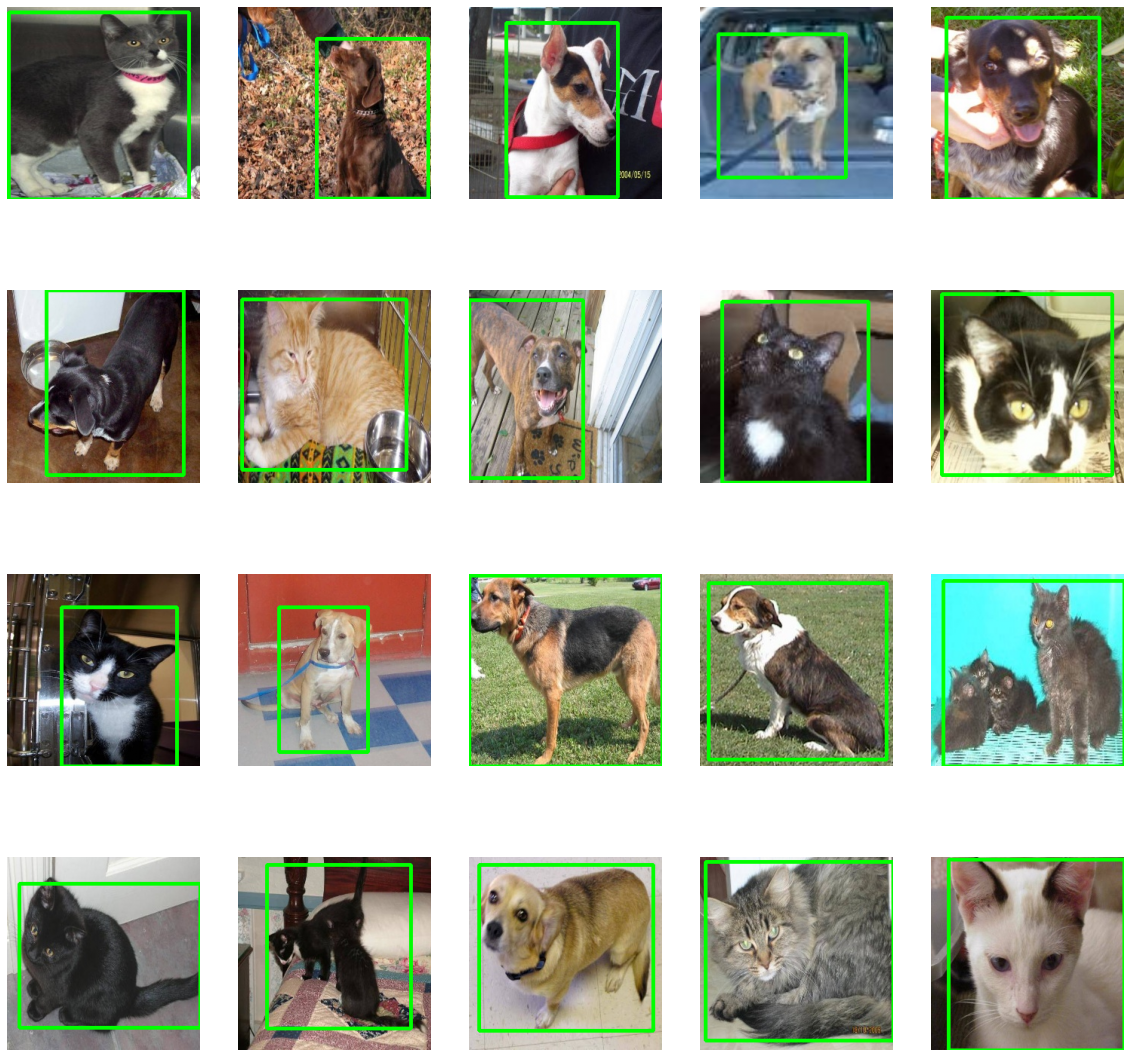

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(img_list)), 20)

for itr, i in enumerate(random_range, 1):

    # Bounding box of each image
    a1, b1, a2, b2 = boxes[i];
    img_size = 256

    # Rescaling the boundig box values to match the image size
    x1 = a1 * img_size
    x2 = a2 * img_size
    y1 = b1 * img_size
    y2 = b2 * img_size

    # The image to visualize
    image = img_list[i]

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3);
    
    # Clip the values to 0-1 and draw the sample of images
    img = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, itr);
    plt.imshow(img);
    plt.axis('off');

## **Step 5: Split the Data into Train and Validation Set**
Now we would have 3 lists, one list containing all images, the second one contains all class labels in one hot encoded format and the third one list contains scaled bounding box coordinates. Let’s split our data to create a training and validation set. It’s important that you shuffle your data before the split which we have already done.


In [ ]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(labels), np.array(boxes), test_size = 0.2, 
                random_state = 43)

print('Training Images Count: {}, Validation Images Count: {}'.format(
    len(train_images), len(val_images) ))

Training Images Count: 960, Validation Images Count: 240


**PyTorch Libraries**

In [ ]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import random
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class Dataset():
    def __init__(self, train_images, train_labels, train_boxes):
        self.images = torch.permute(torch.from_numpy(train_images),(0,3,1,2)).float()
        self.labels = torch.from_numpy(train_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(train_boxes).float()

    def __len__(self):
        return len(self.labels)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.labels[idx],
              self.boxes[idx])

# Inheriting from Dataset class

class ValDataset(Dataset):

    def __init__(self, val_images, val_labels, val_boxes):

        self.images = torch.permute(torch.from_numpy(val_images),(0,3,1,2)).float()
        self.labels = torch.from_numpy(val_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(val_boxes).float()


# Model Architecture

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # CNNs for rgb images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=5)


        # Connecting CNN outputs with Fully Connected layers
        self.class_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.class_fc2 = nn.Linear(in_features=240, out_features=120)
        self.class_out = nn.Linear(in_features=120, out_features=2)

        # Connecting CNN outputs with Fully Connected layers
        self.box_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.box_fc2 = nn.Linear(in_features=240, out_features=120)
        self.box_out = nn.Linear(in_features=120, out_features=4)


    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)
        

        # print("HERE",t.size())

        t = torch.flatten(t,start_dim=1)
        

        class_t = self.class_fc1(t)
        class_t = F.relu(class_t)

        class_t = self.class_fc2(class_t)
        class_t = F.relu(class_t)

        class_t = F.softmax(self.class_out(class_t),dim=1)

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        box_t = F.sigmoid(box_t)

        return [class_t,box_t]

In [ ]:
model = Network()
model = model.to(device)
model

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 192, kernel_size=(5, 5), stride=(1, 1))
  (class_fc1): Linear(in_features=1728, out_features=240, bias=True)
  (class_fc2): Linear(in_features=240, out_features=120, bias=True)
  (class_out): Linear(in_features=120, out_features=2, bias=True)
  (box_fc1): Linear(in_features=1728, out_features=240, bias=True)
  (box_fc2): Linear(in_features=240, out_features=120, bias=True)
  (box_out): Linear(in_features=120, out_features=4, bias=True)
)

In [ ]:
dataset = Dataset(train_images, train_labels, train_boxes)

In [ ]:
valdataset = ValDataset(val_images, val_labels, val_boxes)

In [ ]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [ ]:
# dataloader in pytorch to load validation and train dataset
dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=True)
# , num_workers=2)
valdataloader = torch.utils.data.DataLoader(
        valdataset, batch_size=32, shuffle=True)
        
os.mkdir('models')

# Training Script

In [ ]:
def train(model):
    # Defining the optimizer
    optimizer = optim.SGD(model.parameters(),lr = 0.1)
    num_of_epochs = 30
    epochs = []
    losses = []
    start = time.time()
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        train_start = time.time()

        # Sets the model to train mode
        model.train()
        for batch, (x, y, z) in enumerate(dataloader):
            x,y,z = x.to(device),y.to(device),z.to(device)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            [y_pred,z_pred]= model(x)
            # Compute loss (here CrossEntropyLoss)
            class_loss = F.cross_entropy(y_pred, y)
            box_loss = F.mse_loss(z_pred, z)
            (box_loss + class_loss).backward()
            # class_loss.backward()
            optimizer.step()
            print("Train batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')

        # Sets the model to eval mode
        model.eval()
        for batch, (x, y,z) in enumerate(valdataloader):
            # Convert the data to GPU(the device available)
            x,y,z = x.to(device),y.to(device),z.to(device)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                [y_pred,z_pred]= model(x)

                # Compute loss (here CrossEntropyLoss)
                class_loss = F.cross_entropy(y_pred, y)
                
                # Compute loss (here Mean Sqaured Error)
                box_loss = F.mse_loss(z_pred, z)

            tot_loss += (class_loss.item() + box_loss.item())
            tot_correct += get_num_correct(y_pred, y)
            print("Test batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch", epoch, "Accuracy", (tot_correct)/2.4, "loss:",
              tot_loss, " time: ", (time.time()-train_start)/60, " mins")
        torch.save(model.state_dict(), "models/model_ep"+str(epoch+1)+".pth")


In [ ]:
model = Network()
model = model.to(device)
train(model)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1929: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train batch: 1  epoch:  0   0.056832977135976154
Train batch: 2  epoch:  0   0.05740172068277995
Train batch: 3  epoch:  0   0.05807302395502726
Train batch: 4  epoch:  0   0.058744255701700845
Train batch: 5  epoch:  0   0.05941151777903239


Train batch: 7  epoch:  0   0.06076904137929281
Train batch: 8  epoch:  0   0.06141139268875122
Train batch: 9  epoch:  0   0.06203999916712443
Train batch: 10  epoch:  0   0.06269554694493612
Train batch: 11  epoch:  0   0.06332260370254517


Train batch: 13  epoch:  0   0.06453992128372192
Train batch: 14  epoch:  0   0.06512830257415772
Train batch: 15  epoch:  0   0.0657160480817159
Train batch: 16  epoch:  0   0.0663112998008728
Train batch: 17  epoch:  0   0.06685770750045776


Train batch: 19  epoch:  0   0.06795265277226765
Train batch: 20  epoch:  0   0.0684853434562683
Train batch: 21  epoch:  0   0.06902630726496378
Train batch: 22  epoch:  0   0.06957505544026693
Train batch: 23  epoch:  0   0.07008914550145467
Train batch: 24  epoch:  0   0.0706156571706136


Train batch: 26  epoch:  0   0.0716836174329122
Train batch: 27  epoch:  0   0.07220831314722696
Train batch: 28  epoch:  0   0.07272520860036215
Train batch: 29  epoch:  0   0.07325379451115926
Train batch: 30  epoch:  0   0.07378187576929728
Test batch: 1  epoch:  0   0.07442553043365478


Test batch: 3  epoch:  0   0.07523555755615234
Test batch: 4  epoch:  0   0.07566643953323364
Test batch: 5  epoch:  0   0.07604637543360392
Test batch: 6  epoch:  0   0.0764326294263204
Test batch: 7  epoch:  0   0.07682051261266072
Test batch: 8  epoch:  0   0.07704114119211833
Epoch 0 Accuracy 44.583333333333336 loss: 6.6665167808532715  time:  0.07710058291753133  mins


Train batch: 1  epoch:  1   0.00037393967310587567
Train batch: 2  epoch:  1   0.0009054303169250488
Train batch: 3  epoch:  1   0.0014381090799967448
Train batch: 4  epoch:  1   0.0019515752792358398
Train batch: 5  epoch:  1   0.0024511297543843586
Train batch: 6  epoch:  1   0.0029703299204508465


Train batch: 8  epoch:  1   0.004032941659291586
Train batch: 9  epoch:  1   0.0045567472775777185
Train batch: 10  epoch:  1   0.005089406172434489
Train batch: 11  epoch:  1   0.005613386631011963
Train batch: 12  epoch:  1   0.0061419924100240076
Train batch: 13  epoch:  1   0.006666648387908936


Train batch: 15  epoch:  1   0.0077414313952128095
Train batch: 16  epoch:  1   0.008269158999125163
Train batch: 17  epoch:  1   0.008790290355682373
Train batch: 18  epoch:  1   0.009308520952860515
Train batch: 19  epoch:  1   0.009893278280893961
Train batch: 20  epoch:  1   0.010370206832885743


Train batch: 22  epoch:  1   0.01147158940633138
Train batch: 23  epoch:  1   0.012024947007497152
Train batch: 24  epoch:  1   0.012548474470774333
Train batch: 25  epoch:  1   0.013079202175140381
Train batch: 26  epoch:  1   0.013608054320017497
Train batch: 27  epoch:  1   0.01413506269454956


Train batch: 29  epoch:  1   0.015189254283905029
Train batch: 30  epoch:  1   0.015707850456237793
Test batch: 1  epoch:  1   0.016309837500254314
Test batch: 2  epoch:  1   0.01675342321395874
Test batch: 3  epoch:  1   0.017319695154825846
Test batch: 4  epoch:  1   0.017752528190612793


Test batch: 6  epoch:  1   0.01891411542892456
Test batch: 7  epoch:  1   0.01930625836054484
Test batch: 8  epoch:  1   0.019510324796040854
Epoch 1 Accuracy 44.583333333333336 loss: 6.447207733988762  time:  0.01956355571746826  mins


Train batch: 1  epoch:  2   0.0003195762634277344
Train batch: 2  epoch:  2   0.0008340279261271158
Train batch: 3  epoch:  2   0.0013761679331461588
Train batch: 4  epoch:  2   0.0018993258476257325
Train batch: 5  epoch:  2   0.0024084925651550295
Train batch: 6  epoch:  2   0.00296708345413208


Train batch: 8  epoch:  2   0.003992517789204915
Train batch: 9  epoch:  2   0.0045024673144022625
Train batch: 10  epoch:  2   0.004989329973856608
Train batch: 11  epoch:  2   0.005501107374827067
Train batch: 12  epoch:  2   0.00601654847462972
Train batch: 13  epoch:  2   0.006508886814117432


Train batch: 15  epoch:  2   0.007600915431976318
Train batch: 16  epoch:  2   0.008108564217885335
Train batch: 17  epoch:  2   0.008631308873494467
Train batch: 18  epoch:  2   0.009154884020487468
Train batch: 19  epoch:  2   0.009681495030721028
Train batch: 20  epoch:  2   0.01021587053934733


Train batch: 22  epoch:  2   0.011267272631327312
Train batch: 23  epoch:  2   0.011794769763946533
Train batch: 24  epoch:  2   0.012309134006500244
Train batch: 25  epoch:  2   0.012833789984385172
Train batch: 26  epoch:  2   0.013359129428863525
Train batch: 27  epoch:  2   0.013896381855010987


Train batch: 29  epoch:  2   0.014947116374969482
Train batch: 30  epoch:  2   0.015468291441599528
Test batch: 1  epoch:  2   0.01605433225631714
Test batch: 2  epoch:  2   0.016441706816355386
Test batch: 3  epoch:  2   0.016834859053293863
Test batch: 4  epoch:  2   0.01729583740234375
Test batch: 5  epoch:  2   0.017889793713887533


Test batch: 7  epoch:  2   0.018668651580810547
Test batch: 8  epoch:  2   0.018888866901397704
Epoch 2 Accuracy 44.583333333333336 loss: 6.262692831456661  time:  0.018975289662679036  mins
Train batch: 1  epoch:  3   0.0005245566368103028


Train batch: 3  epoch:  3   0.0015533447265625
Train batch: 4  epoch:  3   0.0020613749821980793
Train batch: 5  epoch:  3   0.002584954102834066
Train batch: 6  epoch:  3   0.003094927469889323
Train batch: 7  epoch:  3   0.0036019245783487958
Train batch: 8  epoch:  3   0.004117298126220703


Train batch: 10  epoch:  3   0.005157633622487386
Train batch: 11  epoch:  3   0.005665711561838786
Train batch: 12  epoch:  3   0.006188627084096273
Train batch: 13  epoch:  3   0.006711773077646891
Train batch: 14  epoch:  3   0.0072414120038350425
Train batch: 15  epoch:  3   0.007777055104573567


Train batch: 17  epoch:  3   0.008801110585530599
Train batch: 18  epoch:  3   0.009321049849192301
Train batch: 19  epoch:  3   0.00983709494272868
Train batch: 20  epoch:  3   0.01034312645594279
Train batch: 21  epoch:  3   0.010891071955362956
Train batch: 22  epoch:  3   0.011403278509775797


Train batch: 24  epoch:  3   0.01243898868560791
Train batch: 25  epoch:  3   0.012945866584777832
Train batch: 26  epoch:  3   0.013447880744934082
Train batch: 27  epoch:  3   0.013959074020385742
Train batch: 28  epoch:  3   0.014462800820668538
Train batch: 29  epoch:  3   0.01497725248336792


Test batch: 1  epoch:  3   0.016067230701446535
Test batch: 2  epoch:  3   0.0164451797803243
Test batch: 3  epoch:  3   0.01682662566502889
Test batch: 4  epoch:  3   0.017252675692240396
Test batch: 5  epoch:  3   0.01782360871632894
Test batch: 6  epoch:  3   0.01838335593541463
Test batch: 7  epoch:  3   0.018796984354654947
Test batch: 8  epoch:  3   0.019097463289896647
Epoch 3 Accuracy 44.583333333333336 loss: 6.110107183456421  time:  0.01910164753595988  mins


Train batch: 1  epoch:  4   0.00035881996154785156
Train batch: 2  epoch:  4   0.0009029547373453777
Train batch: 3  epoch:  4   0.0014703710873921712
Train batch: 4  epoch:  4   0.0020310203234354656
Train batch: 5  epoch:  4   0.0025707920392354327
Train batch: 6  epoch:  4   0.003099389870961507


Train batch: 8  epoch:  4   0.004175941149393718
Train batch: 9  epoch:  4   0.004674553871154785
Train batch: 10  epoch:  4   0.005190066496531169
Train batch: 11  epoch:  4   0.005726969242095948
Train batch: 12  epoch:  4   0.006242227554321289
Train batch: 13  epoch:  4   0.006766291459401449


Train batch: 15  epoch:  4   0.007812682787577312
Train batch: 16  epoch:  4   0.008400030930836995
Train batch: 17  epoch:  4   0.008937358856201172
Train batch: 18  epoch:  4   0.009462388356526692
Train batch: 19  epoch:  4   0.009989651044209798
Train batch: 20  epoch:  4   0.010511215527852375


Train batch: 22  epoch:  4   0.01155788501103719
Train batch: 23  epoch:  4   0.012083935737609863
Train batch: 24  epoch:  4   0.0125999649365743
Train batch: 25  epoch:  4   0.013141504923502604
Train batch: 26  epoch:  4   0.01366286277770996
Train batch: 27  epoch:  4   0.014171870549519856


Train batch: 29  epoch:  4   0.015256090958913168
Train batch: 30  epoch:  4   0.015761729081471762
Test batch: 1  epoch:  4   0.016337104638417563
Test batch: 2  epoch:  4   0.016717620690663657
Test batch: 3  epoch:  4   0.017111027240753175
Test batch: 4  epoch:  4   0.017540748914082846


Test batch: 6  epoch:  4   0.01872084935506185
Test batch: 7  epoch:  4   0.01914154291152954
Test batch: 8  epoch:  4   0.01936902602513631
Epoch 4 Accuracy 44.583333333333336 loss: 5.974728785455227  time:  0.019422590732574463  mins


Train batch: 1  epoch:  5   0.000317231814066569
Train batch: 2  epoch:  5   0.0008403499921162923
Train batch: 3  epoch:  5   0.0013612747192382813
Train batch: 4  epoch:  5   0.0018967111905415853
Train batch: 5  epoch:  5   0.0024114529291788737
Train batch: 6  epoch:  5   0.0029421448707580566


Train batch: 8  epoch:  5   0.003984475135803222
Train batch: 9  epoch:  5   0.00450820525487264
Train batch: 10  epoch:  5   0.005035984516143799
Train batch: 11  epoch:  5   0.005557525157928467
Train batch: 12  epoch:  5   0.006074559688568115
Train batch: 13  epoch:  5   0.006600979963938395


Train batch: 15  epoch:  5   0.007652199268341065
Train batch: 16  epoch:  5   0.008177240689595541
Train batch: 17  epoch:  5   0.008700108528137207
Train batch: 18  epoch:  5   0.00922703742980957
Train batch: 19  epoch:  5   0.00974193811416626
Train batch: 20  epoch:  5   0.010268465677897135


Train batch: 22  epoch:  5   0.011298378308614096
Train batch: 23  epoch:  5   0.011807088057200115
Train batch: 24  epoch:  5   0.012324261665344238
Train batch: 25  epoch:  5   0.012837763627370198
Train batch: 26  epoch:  5   0.013358743985493977
Train batch: 27  epoch:  5   0.013890993595123292


Train batch: 29  epoch:  5   0.014930097262064616
Train batch: 30  epoch:  5   0.0154593825340271
Test batch: 1  epoch:  5   0.01602314313252767
Test batch: 2  epoch:  5   0.016627391179402668
Test batch: 3  epoch:  5   0.017046674092610677
Test batch: 4  epoch:  5   0.017452506224314372


Test batch: 6  epoch:  5   0.01827268600463867
Test batch: 7  epoch:  5   0.018668278058369955
Test batch: 8  epoch:  5   0.01888738473256429
Epoch 5 Accuracy 44.583333333333336 loss: 5.848365526646376  time:  0.01889723539352417  mins


Train batch: 2  epoch:  6   0.0011265079180399578
Train batch: 3  epoch:  6   0.0016537070274353026
Train batch: 4  epoch:  6   0.0021802107493082683
Train batch: 5  epoch:  6   0.002706098556518555
Train batch: 6  epoch:  6   0.0032305479049682616
Train batch: 7  epoch:  6   0.0038047075271606446


Train batch: 9  epoch:  6   0.004825560251871744
Train batch: 10  epoch:  6   0.0053522666295369465
Train batch: 11  epoch:  6   0.0058824102083841956
Train batch: 12  epoch:  6   0.006413841247558593
Train batch: 13  epoch:  6   0.006945315996805827
Train batch: 14  epoch:  6   0.0074622790018717446


Train batch: 16  epoch:  6   0.008535504341125488
Train batch: 17  epoch:  6   0.00905304749806722
Train batch: 18  epoch:  6   0.0095787247021993
Train batch: 19  epoch:  6   0.01009041468302409
Train batch: 20  epoch:  6   0.01060173511505127
Train batch: 21  epoch:  6   0.011117227872212728


Train batch: 23  epoch:  6   0.012132235368092855
Train batch: 24  epoch:  6   0.0127028226852417
Train batch: 25  epoch:  6   0.013227629661560058
Train batch: 26  epoch:  6   0.013748069604237875
Train batch: 27  epoch:  6   0.01431124210357666
Train batch: 28  epoch:  6   0.01482019821802775


Train batch: 30  epoch:  6   0.015854612986246745
Test batch: 1  epoch:  6   0.01643423636754354
Test batch: 2  epoch:  6   0.01681036949157715
Test batch: 3  epoch:  6   0.017188107967376708
Test batch: 4  epoch:  6   0.01757686138153076
Test batch: 5  epoch:  6   0.01796725591023763
Test batch: 6  epoch:  6   0.018349595864613853
Test batch: 7  epoch:  6   0.018771191438039143
Test batch: 8  epoch:  6   0.01908212900161743
Epoch 6 Accuracy 43.333333333333336 loss: 5.673439988866448  time:  0.019093751907348633  mins


Train batch: 1  epoch:  7   0.00034205913543701173
Train batch: 2  epoch:  7   0.00085297425587972
Train batch: 3  epoch:  7   0.0013907353083292644
Train batch: 4  epoch:  7   0.0018870433171590169
Train batch: 5  epoch:  7   0.002404888470967611
Train batch: 6  epoch:  7   0.002919646104176839


Train batch: 8  epoch:  7   0.003935035069783529
Train batch: 9  epoch:  7   0.004461101690928141
Train batch: 10  epoch:  7   0.004982086022694906
Train batch: 11  epoch:  7   0.0054814775784810385
Train batch: 12  epoch:  7   0.005989499886830648
Train batch: 13  epoch:  7   0.006497530142466227


Train batch: 15  epoch:  7   0.007524752616882324
Train batch: 16  epoch:  7   0.008046253522237142
Train batch: 17  epoch:  7   0.00855412483215332
Train batch: 18  epoch:  7   0.009065282344818116
Train batch: 19  epoch:  7   0.009581188360850016
Train batch: 20  epoch:  7   0.010104147593180339


Train batch: 22  epoch:  7   0.01115322510401408
Train batch: 23  epoch:  7   0.011670271555582682
Train batch: 24  epoch:  7   0.012216587861378988
Train batch: 25  epoch:  7   0.012744518121083577
Train batch: 26  epoch:  7   0.013304173946380615
Train batch: 27  epoch:  7   0.013885875542958578


Train batch: 29  epoch:  7   0.014943333466847737
Train batch: 30  epoch:  7   0.015461130936940511
Test batch: 1  epoch:  7   0.016033240159352622
Test batch: 2  epoch:  7   0.016412770748138426
Test batch: 3  epoch:  7   0.016984772682189942
Test batch: 4  epoch:  7   0.017355839411417644
Test batch: 5  epoch:  7   0.017746814092000327


Test batch: 7  epoch:  7   0.018520545959472657
Test batch: 8  epoch:  7   0.018746658166249593
Epoch 7 Accuracy 43.333333333333336 loss: 5.686097308062017  time:  0.018757081031799315  mins


Train batch: 2  epoch:  8   0.001132039229075114
Train batch: 3  epoch:  8   0.001693244775136312
Train batch: 4  epoch:  8   0.0022310932477315267
Train batch: 5  epoch:  8   0.002720761299133301
Train batch: 6  epoch:  8   0.0032563209533691406
Train batch: 7  epoch:  8   0.0037604212760925294


Train batch: 9  epoch:  8   0.004832037289937337
Train batch: 10  epoch:  8   0.0053586204846700035
Train batch: 11  epoch:  8   0.005958120028177897
Train batch: 12  epoch:  8   0.0064755439758300785
Train batch: 13  epoch:  8   0.006998713811238607
Train batch: 14  epoch:  8   0.007516117890675863


Train batch: 16  epoch:  8   0.008558320999145507
Train batch: 17  epoch:  8   0.00908368428548177
Train batch: 18  epoch:  8   0.009598898887634277
Train batch: 19  epoch:  8   0.010128732522328694
Train batch: 20  epoch:  8   0.010655613740285237
Train batch: 21  epoch:  8   0.011193021138509115


Train batch: 23  epoch:  8   0.012282637755076091
Train batch: 24  epoch:  8   0.012808386484781902
Train batch: 25  epoch:  8   0.013390688101450603
Train batch: 26  epoch:  8   0.013914863268534342
Train batch: 27  epoch:  8   0.01443936030069987
Train batch: 28  epoch:  8   0.015007420380910238


Train batch: 30  epoch:  8   0.016113797823588055
Test batch: 1  epoch:  8   0.016749445597330728
Test batch: 2  epoch:  8   0.017345511913299562
Test batch: 3  epoch:  8   0.017945897579193116
Test batch: 4  epoch:  8   0.01833955446879069
Test batch: 5  epoch:  8   0.018750703334808348


Test batch: 7  epoch:  8   0.01951413949330648
Test batch: 8  epoch:  8   0.019723983605702718
Epoch 8 Accuracy 43.75 loss: 5.739154416136444  time:  0.019743478298187254  mins


Train batch: 2  epoch:  9   0.0011298537254333496
Train batch: 3  epoch:  9   0.0016535282135009765
Train batch: 4  epoch:  9   0.002220559120178223
Train batch: 5  epoch:  9   0.002734732627868652
Train batch: 6  epoch:  9   0.0032576799392700197
Train batch: 7  epoch:  9   0.0038292924563090008


Train batch: 9  epoch:  9   0.0048745512962341305
Train batch: 10  epoch:  9   0.005395261446634928
Train batch: 11  epoch:  9   0.005918244520823161
Train batch: 12  epoch:  9   0.00643989642461141
Train batch: 13  epoch:  9   0.006963702042897543
Train batch: 14  epoch:  9   0.007487877209981283


Train batch: 16  epoch:  9   0.00854727824529012
Train batch: 17  epoch:  9   0.009068930149078369
Train batch: 18  epoch:  9   0.00961227019627889
Train batch: 19  epoch:  9   0.010130973656972249
Train batch: 20  epoch:  9   0.010661689440409343
Train batch: 21  epoch:  9   0.011185630162556966


Train batch: 23  epoch:  9   0.012254408995310466
Train batch: 24  epoch:  9   0.012776613235473633
Train batch: 25  epoch:  9   0.013293782869974772
Train batch: 26  epoch:  9   0.013819738229115804
Train batch: 27  epoch:  9   0.014342558383941651
Train batch: 28  epoch:  9   0.014879175027211507


Train batch: 30  epoch:  9   0.01592946449915568
Test batch: 1  epoch:  9   0.016527314980824787
Test batch: 2  epoch:  9   0.016918567816416423
Test batch: 3  epoch:  9   0.01749923626581828
Test batch: 4  epoch:  9   0.01794061263402303
Test batch: 5  epoch:  9   0.01852994362513224


Test batch: 7  epoch:  9   0.019545404116312663
Test batch: 8  epoch:  9   0.01986571153004964
Epoch 9 Accuracy 43.333333333333336 loss: 5.700150277465582  time:  0.01988034645716349  mins
Train batch: 1  epoch:  10   0.00031978686650594075


Train batch: 3  epoch:  10   0.0013424992561340333
Train batch: 4  epoch:  10   0.0018686532974243164
Train batch: 5  epoch:  10   0.0023902376492818196
Train batch: 6  epoch:  10   0.002908011277516683
Train batch: 7  epoch:  10   0.003415783246358236
Train batch: 8  epoch:  10   0.003942259152730306


Train batch: 10  epoch:  10   0.005000853538513183
Train batch: 11  epoch:  10   0.005537577470143636
Train batch: 12  epoch:  10   0.006053646405537923
Train batch: 13  epoch:  10   0.0066147367159525555
Train batch: 14  epoch:  10   0.007114473978678385
Train batch: 15  epoch:  10   0.0076751232147216795


Train batch: 17  epoch:  10   0.008815364042917887
Train batch: 18  epoch:  10   0.009328230222066244
Train batch: 19  epoch:  10   0.009867640336354573
Train batch: 20  epoch:  10   0.0103910764058431
Train batch: 21  epoch:  10   0.010910916328430175
Train batch: 22  epoch:  10   0.011438143253326417


Train batch: 24  epoch:  10   0.012503254413604736
Train batch: 25  epoch:  10   0.013018361727396647
Train batch: 26  epoch:  10   0.013542755444844564
Train batch: 27  epoch:  10   0.014044559001922608
Train batch: 28  epoch:  10   0.01456765333811442
Train batch: 29  epoch:  10   0.01509318749109904


Test batch: 1  epoch:  10   0.01617431640625
Test batch: 2  epoch:  10   0.01675470272699992
Test batch: 3  epoch:  10   0.017323756217956544
Test batch: 4  epoch:  10   0.01769332488377889
Test batch: 5  epoch:  10   0.01807221571604411
Test batch: 6  epoch:  10   0.01844711701075236
Test batch: 7  epoch:  10   0.018826103210449217
Test batch: 8  epoch:  10   0.01904772122701009
Epoch 10 Accuracy 43.333333333333336 loss: 5.712756171356887  time:  0.01905325651168823  mins


Train batch: 1  epoch:  11   0.0003558953603108724
Train batch: 2  epoch:  11   0.0009039481480916341
Train batch: 3  epoch:  11   0.0014309247334798178
Train batch: 4  epoch:  11   0.001949624220530192
Train batch: 5  epoch:  11   0.002464453379313151
Train batch: 6  epoch:  11   0.0029741843541463216


Train batch: 8  epoch:  11   0.003998645146687825
Train batch: 9  epoch:  11   0.00457992156346639
Train batch: 10  epoch:  11   0.0051483154296875
Train batch: 11  epoch:  11   0.005707140763600667
Train batch: 12  epoch:  11   0.006300004323323568


Train batch: 14  epoch:  11   0.007445645332336426
Train batch: 15  epoch:  11   0.007928967475891113
Train batch: 16  epoch:  11   0.008439854780832926
Train batch: 17  epoch:  11   0.008972585201263428
Train batch: 18  epoch:  11   0.009492425123850505
Train batch: 19  epoch:  11   0.010011819998423259


Train batch: 21  epoch:  11   0.011044565836588542
Train batch: 22  epoch:  11   0.011558822790781657
Train batch: 23  epoch:  11   0.012064043680826824
Train batch: 24  epoch:  11   0.01257779598236084
Train batch: 25  epoch:  11   0.013093105951944987
Train batch: 26  epoch:  11   0.013618874549865722


Train batch: 28  epoch:  11   0.014639015992482502
Train batch: 29  epoch:  11   0.015159114201863607
Train batch: 30  epoch:  11   0.015681115786234538
Test batch: 1  epoch:  11   0.016252652804056803
Test batch: 2  epoch:  11   0.01663657029469808
Test batch: 3  epoch:  11   0.017277201016743977


Test batch: 5  epoch:  11   0.018162985642751057
Test batch: 6  epoch:  11   0.018568015098571776
Test batch: 7  epoch:  11   0.01902302900950114
Test batch: 8  epoch:  11   0.019339696566263834
Epoch 11 Accuracy 43.333333333333336 loss: 5.716969809494913  time:  0.019355257352193195  mins


Train batch: 1  epoch:  12   0.0003616650899251302
Train batch: 2  epoch:  12   0.000865018367767334
Train batch: 3  epoch:  12   0.0014118234316507976
Train batch: 4  epoch:  12   0.0019286513328552247
Train batch: 5  epoch:  12   0.002468268076578776
Train batch: 6  epoch:  12   0.002996428807576497


Train batch: 8  epoch:  12   0.004101375738779704
Train batch: 9  epoch:  12   0.0046730438868204755
Train batch: 10  epoch:  12   0.00540848175684611
Train batch: 11  epoch:  12   0.005916666984558105
Train batch: 12  epoch:  12   0.006438728173573812


Train batch: 14  epoch:  12   0.007502981026967366
Train batch: 15  epoch:  12   0.008009835084279378
Train batch: 16  epoch:  12   0.00857702096303304
Train batch: 17  epoch:  12   0.009068524837493897
Train batch: 18  epoch:  12   0.00959245761235555
Train batch: 19  epoch:  12   0.01012109120686849


Train batch: 21  epoch:  12   0.011175274848937988
Train batch: 22  epoch:  12   0.011722977956136067
Train batch: 23  epoch:  12   0.012245750427246094
Train batch: 24  epoch:  12   0.012764998277028402
Train batch: 25  epoch:  12   0.013331786791483561
Train batch: 26  epoch:  12   0.013892575105031332


Train batch: 28  epoch:  12   0.01495359738667806
Train batch: 29  epoch:  12   0.015465561548868816
Train batch: 30  epoch:  12   0.01598803997039795
Test batch: 1  epoch:  12   0.016563427448272706
Test batch: 2  epoch:  12   0.016936413447062173
Test batch: 3  epoch:  12   0.017506603399912515
Test batch: 4  epoch:  12   0.017885518074035645


Test batch: 6  epoch:  12   0.01866542895634969
Test batch: 7  epoch:  12   0.019114689032236735
Test batch: 8  epoch:  12   0.019433232148488362
Epoch 12 Accuracy 43.333333333333336 loss: 5.718473354354501  time:  0.019449321428934734  mins


Train batch: 1  epoch:  13   0.0003418445587158203
Train batch: 2  epoch:  13   0.0008689721425374348
Train batch: 3  epoch:  13   0.0013938426971435546
Train batch: 4  epoch:  13   0.0019159317016601562
Train batch: 5  epoch:  13   0.002451920509338379
Train batch: 6  epoch:  13   0.002941421667734782


Train batch: 8  epoch:  13   0.0040778636932373045
Train batch: 9  epoch:  13   0.0046455621719360355
Train batch: 10  epoch:  13   0.005167579650878907
Train batch: 11  epoch:  13   0.005688003698984782
Train batch: 12  epoch:  13   0.006222716967264811
Train batch: 13  epoch:  13   0.006739997863769531


Train batch: 15  epoch:  13   0.00783316691716512
Train batch: 16  epoch:  13   0.00837479035059611
Train batch: 17  epoch:  13   0.008912901083628336
Train batch: 18  epoch:  13   0.009415725866953531
Train batch: 19  epoch:  13   0.009942460060119628
Train batch: 20  epoch:  13   0.010482776165008544


Train batch: 22  epoch:  13   0.011475821336110434
Train batch: 23  epoch:  13   0.011987066268920899
Train batch: 24  epoch:  13   0.012504768371582032
Train batch: 25  epoch:  13   0.01306216319402059
Train batch: 26  epoch:  13   0.013581907749176026
Train batch: 27  epoch:  13   0.014092083772023518


Train batch: 29  epoch:  13   0.015114474296569824
Train batch: 30  epoch:  13   0.015625492731730143
Test batch: 1  epoch:  13   0.016207559903462728
Test batch: 2  epoch:  13   0.01662254730860392
Test batch: 3  epoch:  13   0.017020094394683837
Test batch: 4  epoch:  13   0.017410163084665933
Test batch: 5  epoch:  13   0.017802345752716064


Test batch: 7  epoch:  13   0.018586464722951255
Test batch: 8  epoch:  13   0.018802877267201742
Epoch 13 Accuracy 41.66666666666667 loss: 5.7101824302226305  time:  0.01881267229715983  mins


Train batch: 1  epoch:  14   0.00033244689305623375
Train batch: 2  epoch:  14   0.0008561809857686361
Train batch: 3  epoch:  14   0.0013828555742899577
Train batch: 4  epoch:  14   0.0019104679425557454
Train batch: 5  epoch:  14   0.0024366378784179688
Train batch: 6  epoch:  14   0.0029668649037679034


Train batch: 8  epoch:  14   0.0040185809135437015
Train batch: 9  epoch:  14   0.004586660861968994
Train batch: 10  epoch:  14   0.005123452345530192
Train batch: 11  epoch:  14   0.005657502015431722
Train batch: 12  epoch:  14   0.006178704897562662
Train batch: 13  epoch:  14   0.006705474853515625


Train batch: 15  epoch:  14   0.007749493916829427
Train batch: 16  epoch:  14   0.00827186107635498
Train batch: 17  epoch:  14   0.00880287488301595
Train batch: 18  epoch:  14   0.009326473871866862
Train batch: 19  epoch:  14   0.009909896055857341
Train batch: 20  epoch:  14   0.01045289436976115


Train batch: 22  epoch:  14   0.011505214373270671
Train batch: 23  epoch:  14   0.012021199862162272
Train batch: 24  epoch:  14   0.012553846836090088
Train batch: 25  epoch:  14   0.013070801893870035
Train batch: 26  epoch:  14   0.01359854539235433
Train batch: 27  epoch:  14   0.014121389389038086


Train batch: 29  epoch:  14   0.015180949370066326
Train batch: 30  epoch:  14   0.015737334887186687
Test batch: 1  epoch:  14   0.016307310263315836
Test batch: 2  epoch:  14   0.016887990633646648
Test batch: 3  epoch:  14   0.01747259298960368
Test batch: 4  epoch:  14   0.017925330003102622


Test batch: 6  epoch:  14   0.01908552646636963
Test batch: 7  epoch:  14   0.019521431128184
Test batch: 8  epoch:  14   0.01983689864476522
Epoch 14 Accuracy 42.5 loss: 5.733160763978958  time:  0.019841583569844563  mins


Train batch: 1  epoch:  15   0.0003240625063578288
Train batch: 2  epoch:  15   0.0008375843365987142
Train batch: 3  epoch:  15   0.0013605038324991862
Train batch: 4  epoch:  15   0.001912832260131836
Train batch: 5  epoch:  15   0.0024220625559488933
Train batch: 6  epoch:  15   0.0029438177744547525


Train batch: 8  epoch:  15   0.003989235560099284
Train batch: 9  epoch:  15   0.004487284024556478
Train batch: 10  epoch:  15   0.005067797501881918
Train batch: 11  epoch:  15   0.005566199620564778
Train batch: 12  epoch:  15   0.006085387865702311
Train batch: 13  epoch:  15   0.006598969300587972


Train batch: 15  epoch:  15   0.007619325319925944
Train batch: 16  epoch:  15   0.0081427534421285
Train batch: 17  epoch:  15   0.008651189009348552
Train batch: 18  epoch:  15   0.009164988994598389
Train batch: 19  epoch:  15   0.009674481550852458
Train batch: 20  epoch:  15   0.010192453861236572


Train batch: 22  epoch:  15   0.01123034954071045
Train batch: 23  epoch:  15   0.011752426624298096
Train batch: 24  epoch:  15   0.01227133274078369
Train batch: 25  epoch:  15   0.012788740793863933
Train batch: 26  epoch:  15   0.013300995031992594
Train batch: 27  epoch:  15   0.013837134838104248


Train batch: 29  epoch:  15   0.01489506165186564
Train batch: 30  epoch:  15   0.015416435400644938
Test batch: 1  epoch:  15   0.015998772780100503
Test batch: 2  epoch:  15   0.016405196984608968
Test batch: 3  epoch:  15   0.016810067494710288
Test batch: 4  epoch:  15   0.017208409309387208
Test batch: 5  epoch:  15   0.017601418495178222


Test batch: 7  epoch:  15   0.01842707395553589
Test batch: 8  epoch:  15   0.018753000100453696
Epoch 15 Accuracy 43.333333333333336 loss: 5.732605458237231  time:  0.018763681252797444  mins


Train batch: 2  epoch:  16   0.000831445058186849
Train batch: 3  epoch:  16   0.0013524850209554037
Train batch: 4  epoch:  16   0.0018634478251139323
Train batch: 5  epoch:  16   0.002378682295481364
Train batch: 6  epoch:  16   0.0029155890146891276
Train batch: 7  epoch:  16   0.003429881731669108


Train batch: 9  epoch:  16   0.004461129506429036
Train batch: 10  epoch:  16   0.0049843907356262205
Train batch: 11  epoch:  16   0.0055104255676269535
Train batch: 12  epoch:  16   0.006006948153177897
Train batch: 13  epoch:  16   0.006521109739939372
Train batch: 14  epoch:  16   0.00703196922938029


Train batch: 16  epoch:  16   0.008056998252868652
Train batch: 17  epoch:  16   0.008574827512105306
Train batch: 18  epoch:  16   0.009123667081197103
Train batch: 19  epoch:  16   0.009638396898905437
Train batch: 20  epoch:  16   0.010189342498779296
Train batch: 21  epoch:  16   0.010722561677296957


Train batch: 23  epoch:  16   0.011777873833974202
Train batch: 24  epoch:  16   0.012305545806884765
Train batch: 25  epoch:  16   0.012839082876841228
Train batch: 26  epoch:  16   0.013346270720163981
Train batch: 27  epoch:  16   0.013852886358896891
Train batch: 28  epoch:  16   0.014372018973032634


Train batch: 30  epoch:  16   0.015401299794514973
Test batch: 1  epoch:  16   0.015996472040812174
Test batch: 2  epoch:  16   0.016378267606099447
Test batch: 3  epoch:  16   0.016771161556243898
Test batch: 4  epoch:  16   0.017156708240509033
Test batch: 5  epoch:  16   0.01754713853200277
Test batch: 6  epoch:  16   0.017929855982462564
Test batch: 7  epoch:  16   0.018353005250295002
Test batch: 8  epoch:  16   0.018672756354014077
Epoch 16 Accuracy 43.75 loss: 5.780653077177703  time:  0.018687220414479573  mins


Train batch: 1  epoch:  17   0.00032046238581339516
Train batch: 2  epoch:  17   0.0008237838745117187
Train batch: 3  epoch:  17   0.0013460834821065267
Train batch: 4  epoch:  17   0.0018532792727152505
Train batch: 5  epoch:  17   0.002372634410858154
Train batch: 6  epoch:  17   0.002891699473063151


Train batch: 8  epoch:  17   0.003919275601704916
Train batch: 9  epoch:  17   0.004434283574422201
Train batch: 10  epoch:  17   0.004952339331309
Train batch: 11  epoch:  17   0.005470426877339681
Train batch: 12  epoch:  17   0.005983583132425944
Train batch: 13  epoch:  17   0.006487405300140381


Train batch: 15  epoch:  17   0.00758666197458903
Train batch: 16  epoch:  17   0.00809943675994873
Train batch: 17  epoch:  17   0.008610916137695313
Train batch: 18  epoch:  17   0.009127962589263915
Train batch: 19  epoch:  17   0.009638961156209309
Train batch: 20  epoch:  17   0.01015687386194865


Train batch: 22  epoch:  17   0.011179566383361816
Train batch: 23  epoch:  17   0.011705787976582845
Train batch: 24  epoch:  17   0.01228736639022827
Train batch: 25  epoch:  17   0.012804098924001058
Train batch: 26  epoch:  17   0.013330698013305664
Train batch: 27  epoch:  17   0.01387162208557129


Train batch: 29  epoch:  17   0.014904411633809407
Train batch: 30  epoch:  17   0.015439057350158691
Test batch: 1  epoch:  17   0.016017226378122966
Test batch: 2  epoch:  17   0.016563514868418377
Test batch: 3  epoch:  17   0.01712632179260254
Test batch: 4  epoch:  17   0.017505013942718507


Test batch: 6  epoch:  17   0.018270126978556313
Test batch: 7  epoch:  17   0.01869571606318156
Test batch: 8  epoch:  17   0.019008028507232665
Epoch 17 Accuracy 43.333333333333336 loss: 5.7177671156823635  time:  0.019013404846191406  mins


Train batch: 2  epoch:  18   0.0008468310038248698
Train batch: 3  epoch:  18   0.0013566215833028157
Train batch: 4  epoch:  18   0.0018606781959533691
Train batch: 5  epoch:  18   0.002387690544128418
Train batch: 6  epoch:  18   0.0028945008913675943
Train batch: 7  epoch:  18   0.0034083247184753416


Train batch: 9  epoch:  18   0.004448608557383219
Train batch: 10  epoch:  18   0.004974146684010823
Train batch: 11  epoch:  18   0.005496092637379964
Train batch: 12  epoch:  18   0.006003948052724203
Train batch: 13  epoch:  18   0.006525206565856934
Train batch: 14  epoch:  18   0.007049262523651123


Train batch: 16  epoch:  18   0.00808620850245158
Train batch: 17  epoch:  18   0.008595967292785644
Train batch: 18  epoch:  18   0.009113808472951254
Train batch: 19  epoch:  18   0.009629233678181966
Train batch: 20  epoch:  18   0.010136298338572184
Train batch: 21  epoch:  18   0.010645957787831624


Train batch: 23  epoch:  18   0.011690187454223632
Train batch: 24  epoch:  18   0.012198694547017415
Train batch: 25  epoch:  18   0.012707587083180745
Train batch: 26  epoch:  18   0.013226008415222168
Train batch: 27  epoch:  18   0.013743992646535237
Train batch: 28  epoch:  18   0.014256556828816732


Train batch: 30  epoch:  18   0.015295716126759847
Test batch: 1  epoch:  18   0.01587213675181071
Test batch: 2  epoch:  18   0.016245381037394205
Test batch: 3  epoch:  18   0.01660791238149007
Test batch: 4  epoch:  18   0.016972720623016357
Test batch: 5  epoch:  18   0.017377654711405437
Test batch: 6  epoch:  18   0.017754654089609783
Test batch: 7  epoch:  18   0.018172772725423177
Test batch: 8  epoch:  18   0.018382592995961507
Epoch 18 Accuracy 43.333333333333336 loss: 5.75465935934335  time:  0.01839054028193156  mins


Train batch: 1  epoch:  19   0.0003064870834350586
Train batch: 2  epoch:  19   0.0008229255676269531
Train batch: 3  epoch:  19   0.0013414541880289713
Train batch: 4  epoch:  19   0.0019055048624674479
Train batch: 5  epoch:  19   0.0024046977361043293
Train batch: 6  epoch:  19   0.0029140551884969073


Train batch: 8  epoch:  19   0.0039531509081522625
Train batch: 9  epoch:  19   0.004466136296590169
Train batch: 10  epoch:  19   0.0049846847852071125
Train batch: 11  epoch:  19   0.0054923295974731445
Train batch: 12  epoch:  19   0.0060443917910257975
Train batch: 13  epoch:  19   0.006566087404886882


Train batch: 15  epoch:  19   0.007634365558624267
Train batch: 16  epoch:  19   0.008152429262797039
Train batch: 17  epoch:  19   0.008678046862284343
Train batch: 18  epoch:  19   0.00920960505803426
Train batch: 19  epoch:  19   0.009751792748769124
Train batch: 20  epoch:  19   0.010263673464457194


Train batch: 22  epoch:  19   0.011319160461425781
Train batch: 23  epoch:  19   0.011861785252888998
Train batch: 24  epoch:  19   0.012402220567067464
Train batch: 25  epoch:  19   0.012961983680725098
Train batch: 26  epoch:  19   0.013507131735483806
Train batch: 27  epoch:  19   0.014041749636332194


Train batch: 29  epoch:  19   0.015100049972534179
Train batch: 30  epoch:  19   0.015624324480692545
Test batch: 1  epoch:  19   0.016194085280100506
Test batch: 2  epoch:  19   0.01664050022761027
Test batch: 3  epoch:  19   0.0172355055809021
Test batch: 4  epoch:  19   0.017683847745259603


Test batch: 6  epoch:  19   0.018872654438018797
Test batch: 7  epoch:  19   0.01932131846745809
Test batch: 8  epoch:  19   0.019641574223836264
Epoch 19 Accuracy 43.75 loss: 5.747761152219027  time:  0.019661426544189453  mins


Train batch: 1  epoch:  20   0.0003176013628641764
Train batch: 2  epoch:  20   0.00081406831741333
Train batch: 3  epoch:  20   0.001331500212351481
Train batch: 4  epoch:  20   0.0018696745236714682
Train batch: 5  epoch:  20   0.002378531297047933
Train batch: 6  epoch:  20   0.00290449062983195


Train batch: 8  epoch:  20   0.004058257738749186
Train batch: 9  epoch:  20   0.004562497138977051
Train batch: 10  epoch:  20   0.005084089438120524
Train batch: 11  epoch:  20   0.00562590758005778
Train batch: 12  epoch:  20   0.006153404712677002
Train batch: 13  epoch:  20   0.006748632589975993


Train batch: 15  epoch:  20   0.007832213242848714
Train batch: 16  epoch:  20   0.008360560735066731
Train batch: 17  epoch:  20   0.00887372096379598
Train batch: 18  epoch:  20   0.009405569235483805
Train batch: 19  epoch:  20   0.009948527812957764
Train batch: 20  epoch:  20   0.010591801007588704


Train batch: 22  epoch:  20   0.011639583110809325
Train batch: 23  epoch:  20   0.012154881159464519
Train batch: 24  epoch:  20   0.012689479192097982
Train batch: 25  epoch:  20   0.013213785489400227
Train batch: 26  epoch:  20   0.013745522499084473
Train batch: 27  epoch:  20   0.014280474185943604


Train batch: 29  epoch:  20   0.015353413422902425
Train batch: 30  epoch:  20   0.015906262397766113
Test batch: 1  epoch:  20   0.016488055388132732
Test batch: 2  epoch:  20   0.016942922274271646
Test batch: 3  epoch:  20   0.017348392804463705
Test batch: 4  epoch:  20   0.017747330665588378
Test batch: 5  epoch:  20   0.01814812421798706


Test batch: 7  epoch:  20   0.019156150023142495
Test batch: 8  epoch:  20   0.019358527660369874
Epoch 20 Accuracy 51.25 loss: 5.700878861360252  time:  0.019369097550710042  mins
Train batch: 1  epoch:  21   0.0003175814946492513


Train batch: 3  epoch:  21   0.0013558506965637208
Train batch: 4  epoch:  21   0.001881889502207438
Train batch: 5  epoch:  21   0.0024123589197794595
Train batch: 6  epoch:  21   0.002932870388031006
Train batch: 7  epoch:  21   0.003456159432729085
Train batch: 8  epoch:  21   0.0039658665657043455


Train batch: 10  epoch:  21   0.00499113400777181
Train batch: 11  epoch:  21   0.005505128701527914
Train batch: 12  epoch:  21   0.006032371520996093
Train batch: 13  epoch:  21   0.006557575861612956
Train batch: 14  epoch:  21   0.0070822795232137045
Train batch: 15  epoch:  21   0.007611699899037679


Train batch: 17  epoch:  21   0.008683137098948161
Train batch: 18  epoch:  21   0.009207395712534587
Train batch: 19  epoch:  21   0.009729397296905518
Train batch: 20  epoch:  21   0.0102582852045695
Train batch: 21  epoch:  21   0.01079338788986206
Train batch: 22  epoch:  21   0.011318918069203694


Train batch: 24  epoch:  21   0.012367959817250569
Train batch: 25  epoch:  21   0.012911057472229004
Train batch: 26  epoch:  21   0.013423462708791098
Train batch: 27  epoch:  21   0.013944482803344727
Train batch: 28  epoch:  21   0.014456661542256673
Train batch: 29  epoch:  21   0.014968673388163248


Test batch: 1  epoch:  21   0.016069801648457845
Test batch: 2  epoch:  21   0.016477004686991373
Test batch: 3  epoch:  21   0.016933210690816245
Test batch: 4  epoch:  21   0.017512214183807374
Test batch: 5  epoch:  21   0.017900697390238442
Test batch: 6  epoch:  21   0.018283836046854653
Test batch: 7  epoch:  21   0.018670113881429036
Test batch: 8  epoch:  21   0.018894267082214356
Epoch 21 Accuracy 40.833333333333336 loss: 5.747074229642749  time:  0.018898955980936685  mins


Train batch: 1  epoch:  22   0.00038617849349975586
Train batch: 2  epoch:  22   0.0009204665819803874
Train batch: 3  epoch:  22   0.0014469226201375325
Train batch: 4  epoch:  22   0.0019805550575256346
Train batch: 5  epoch:  22   0.0025101423263549803
Train batch: 6  epoch:  22   0.0030459086100260418


Train batch: 8  epoch:  22   0.00410459836324056
Train batch: 9  epoch:  22   0.004635079701741537
Train batch: 10  epoch:  22   0.005172526836395264
Train batch: 11  epoch:  22   0.005716355641682943
Train batch: 12  epoch:  22   0.006240876515706381
Train batch: 13  epoch:  22   0.006784208615620931


Train batch: 15  epoch:  22   0.007826522986094157
Train batch: 16  epoch:  22   0.008349215984344483
Train batch: 17  epoch:  22   0.008883965015411378
Train batch: 18  epoch:  22   0.009413071473439534
Train batch: 19  epoch:  22   0.00994416872660319
Train batch: 20  epoch:  22   0.010461759567260743


Train batch: 22  epoch:  22   0.0115228533744812
Train batch: 23  epoch:  22   0.012067965666453044
Train batch: 24  epoch:  22   0.01258087158203125
Train batch: 25  epoch:  22   0.013161047299702962
Train batch: 26  epoch:  22   0.013658487796783447
Train batch: 27  epoch:  22   0.014180910587310792


Train batch: 29  epoch:  22   0.015255256493886312
Train batch: 30  epoch:  22   0.015770697593688966
Test batch: 1  epoch:  22   0.0163653572400411
Test batch: 2  epoch:  22   0.016751646995544434
Test batch: 3  epoch:  22   0.017188767592112224
Test batch: 4  epoch:  22   0.017780542373657227


Test batch: 6  epoch:  22   0.018783541520436604
Test batch: 7  epoch:  22   0.01916067600250244
Test batch: 8  epoch:  22   0.019379051526387532
Epoch 22 Accuracy 48.75 loss: 5.727976066991687  time:  0.01939732631047567  mins
Train batch: 1  epoch:  23   0.00036433537801106773


Train batch: 3  epoch:  23   0.0013989766438802084
Train batch: 4  epoch:  23   0.001953903834025065
Train batch: 5  epoch:  23   0.0024678746859232584
Train batch: 6  epoch:  23   0.002984015146891276
Train batch: 7  epoch:  23   0.00349193016688029
Train batch: 8  epoch:  23   0.004012763500213623


Train batch: 10  epoch:  23   0.005064491430918376
Train batch: 11  epoch:  23   0.0055953582127889
Train batch: 12  epoch:  23   0.0061193148295084635
Train batch: 13  epoch:  23   0.006648782889048258
Train batch: 14  epoch:  23   0.007223109404246013
Train batch: 15  epoch:  23   0.007762134075164795


Train batch: 17  epoch:  23   0.008858692646026612
Train batch: 18  epoch:  23   0.00936436653137207
Train batch: 19  epoch:  23   0.009889328479766845
Train batch: 20  epoch:  23   0.010421756903330486
Train batch: 21  epoch:  23   0.010952409108479817
Train batch: 22  epoch:  23   0.011471426486968994


Train batch: 24  epoch:  23   0.012612859408060709
Train batch: 25  epoch:  23   0.013131241003672281
Train batch: 26  epoch:  23   0.013666884104410807
Train batch: 27  epoch:  23   0.014184844493865967
Train batch: 28  epoch:  23   0.014718882242838542
Train batch: 29  epoch:  23   0.015252935886383056


Test batch: 1  epoch:  23   0.016367916266123453
Test batch: 2  epoch:  23   0.016801623503367107
Test batch: 3  epoch:  23   0.017362987995147704
Test batch: 4  epoch:  23   0.017801817258199057
Test batch: 5  epoch:  23   0.018401122093200682
Test batch: 6  epoch:  23   0.018990421295166017


Test batch: 8  epoch:  23   0.019744940598805747
Epoch 23 Accuracy 50.0 loss: 5.726508958730847  time:  0.019757604598999022  mins
Train batch: 1  epoch:  24   0.0003260970115661621


Train batch: 3  epoch:  24   0.0014075040817260742
Train batch: 4  epoch:  24   0.0019258022308349609
Train batch: 5  epoch:  24   0.0024574995040893555
Train batch: 6  epoch:  24   0.0029862443606058758
Train batch: 7  epoch:  24   0.0034889539082845053
Train batch: 8  epoch:  24   0.00401076873143514


Train batch: 10  epoch:  24   0.005038853486378988
Train batch: 11  epoch:  24   0.005559297402699789
Train batch: 12  epoch:  24   0.00612633228302002
Train batch: 13  epoch:  24   0.006641507148742676
Train batch: 14  epoch:  24   0.007151130835215251
Train batch: 15  epoch:  24   0.007674328486124675


Train batch: 17  epoch:  24   0.008770445982615152
Train batch: 18  epoch:  24   0.009299711386362711
Train batch: 19  epoch:  24   0.009796400864919027
Train batch: 20  epoch:  24   0.010386069615681967
Train batch: 21  epoch:  24   0.01094750960667928
Train batch: 22  epoch:  24   0.01146841843922933


Train batch: 24  epoch:  24   0.012576893965403239
Train batch: 25  epoch:  24   0.01311632792154948
Train batch: 26  epoch:  24   0.01365206241607666
Train batch: 27  epoch:  24   0.0141617218653361
Train batch: 28  epoch:  24   0.01468642552693685
Train batch: 29  epoch:  24   0.015200463930765788


Test batch: 1  epoch:  24   0.016299418608347573
Test batch: 2  epoch:  24   0.016689173380533853
Test batch: 3  epoch:  24   0.017070841789245606
Test batch: 4  epoch:  24   0.017500897248586018
Test batch: 5  epoch:  24   0.01809026797612508
Test batch: 6  epoch:  24   0.018677135308583576
Test batch: 7  epoch:  24   0.01911871830622355
Test batch: 8  epoch:  24   0.0194635272026062
Epoch 24 Accuracy 42.91666666666667 loss: 5.808260740712285  time:  0.01946769158045451  mins


Train batch: 1  epoch:  25   0.0003053744633992513
Train batch: 2  epoch:  25   0.0008649388949076334
Train batch: 3  epoch:  25   0.001367036501566569
Train batch: 4  epoch:  25   0.0018726030985514322
Train batch: 5  epoch:  25   0.0023882071177164714
Train batch: 6  epoch:  25   0.0028995911280314127


Train batch: 8  epoch:  25   0.003958586851755778
Train batch: 9  epoch:  25   0.0044395724932352705
Train batch: 10  epoch:  25   0.005000539620717366
Train batch: 11  epoch:  25   0.005542254447937012
Train batch: 12  epoch:  25   0.0060579895973205565
Train batch: 13  epoch:  25   0.0065716942151387535


Train batch: 15  epoch:  25   0.007603331406911214
Train batch: 16  epoch:  25   0.008117099603017172
Train batch: 17  epoch:  25   0.008636720975240071
Train batch: 18  epoch:  25   0.009159934520721436
Train batch: 19  epoch:  25   0.009687443574269613
Train batch: 20  epoch:  25   0.010192604859670003


Train batch: 22  epoch:  25   0.011248048146565754
Train batch: 23  epoch:  25   0.011779709657033285
Train batch: 24  epoch:  25   0.012314426898956298
Train batch: 25  epoch:  25   0.01283726692199707
Train batch: 26  epoch:  25   0.01336128314336141
Train batch: 27  epoch:  25   0.013888998826344808


Train batch: 29  epoch:  25   0.014943647384643554
Train batch: 30  epoch:  25   0.015454355875651042
Test batch: 1  epoch:  25   0.016043210029602052
Test batch: 2  epoch:  25   0.01642207702000936
Test batch: 3  epoch:  25   0.016848929723103843
Test batch: 4  epoch:  25   0.017419167359670005
Test batch: 5  epoch:  25   0.017808818817138673


Test batch: 7  epoch:  25   0.01859685977300008
Test batch: 8  epoch:  25   0.018817118803660073
Epoch 25 Accuracy 49.583333333333336 loss: 5.697248784825206  time:  0.018843114376068115  mins


Train batch: 2  epoch:  26   0.0009452462196350098
Train batch: 3  epoch:  26   0.001465447743733724
Train batch: 4  epoch:  26   0.0019977609316507976
Train batch: 5  epoch:  26   0.0025324463844299317
Train batch: 6  epoch:  26   0.0030460755030314126
Train batch: 7  epoch:  26   0.003620620568593343


Train batch: 9  epoch:  26   0.00468143622080485
Train batch: 10  epoch:  26   0.005212887128194173
Train batch: 11  epoch:  26   0.005736843744913737
Train batch: 12  epoch:  26   0.0062606414159139
Train batch: 13  epoch:  26   0.006788885593414307
Train batch: 14  epoch:  26   0.007321790854136149


Train batch: 16  epoch:  26   0.008366485436757406
Train batch: 17  epoch:  26   0.008947598934173583
Train batch: 18  epoch:  26   0.009482026100158691
Train batch: 19  epoch:  26   0.010010778903961182
Train batch: 20  epoch:  26   0.010537771383921306
Train batch: 21  epoch:  26   0.011061600844065348


Train batch: 23  epoch:  26   0.012112311522165934
Train batch: 24  epoch:  26   0.012686570485432943
Train batch: 25  epoch:  26   0.013169010480244955
Train batch: 26  epoch:  26   0.013695867856343587
Train batch: 27  epoch:  26   0.014234522978464762
Train batch: 28  epoch:  26   0.014757009347279866


Train batch: 30  epoch:  26   0.015864316622416177
Test batch: 1  epoch:  26   0.016500266393025716
Test batch: 2  epoch:  26   0.017106592655181885
Test batch: 3  epoch:  26   0.01770482858022054
Test batch: 4  epoch:  26   0.018152928352355956


Test batch: 6  epoch:  26   0.01933005650838216
Test batch: 7  epoch:  26   0.019784645239512125
Test batch: 8  epoch:  26   0.020119325319925944
Epoch 26 Accuracy 53.333333333333336 loss: 5.701038208324462  time:  0.020129152139027915  mins


Train batch: 1  epoch:  27   0.00034629106521606446
Train batch: 2  epoch:  27   0.0008519132932027181
Train batch: 3  epoch:  27   0.0013840277989705405
Train batch: 4  epoch:  27   0.00191118319829305
Train batch: 5  epoch:  27   0.002432886759440104
Train batch: 6  epoch:  27   0.0029576619466145835


Train batch: 8  epoch:  27   0.004008285204569499
Train batch: 9  epoch:  27   0.004533632596333822
Train batch: 10  epoch:  27   0.005065913995107015
Train batch: 11  epoch:  27   0.005593339602152507
Train batch: 12  epoch:  27   0.006120538711547852
Train batch: 13  epoch:  27   0.006650575002034505


Train batch: 15  epoch:  27   0.007927417755126953
Train batch: 16  epoch:  27   0.008453333377838134
Train batch: 17  epoch:  27   0.008970801035563152
Train batch: 18  epoch:  27   0.009524667263031006
Train batch: 19  epoch:  27   0.010078350702921549
Train batch: 20  epoch:  27   0.010608494281768799


Train batch: 22  epoch:  27   0.011674960454305014
Train batch: 23  epoch:  27   0.012206725279490153
Train batch: 24  epoch:  27   0.01277100642522176
Train batch: 25  epoch:  27   0.013362828890482585
Train batch: 26  epoch:  27   0.013883952299753826
Train batch: 27  epoch:  27   0.014412673314412434


Train batch: 29  epoch:  27   0.015464262167612711
Train batch: 30  epoch:  27   0.015990066528320312
Test batch: 1  epoch:  27   0.016594664255777995
Test batch: 2  epoch:  27   0.017008185386657715
Test batch: 3  epoch:  27   0.017406276861826577
Test batch: 4  epoch:  27   0.017844764391581218


Test batch: 6  epoch:  27   0.019055962562561035
Test batch: 7  epoch:  27   0.01949435075124105
Test batch: 8  epoch:  27   0.019827640056610106
Epoch 27 Accuracy 50.833333333333336 loss: 5.7473690854385495  time:  0.019846506913503013  mins


Train batch: 1  epoch:  28   0.00033041238784790037
Train batch: 2  epoch:  28   0.0008341908454895019
Train batch: 3  epoch:  28   0.0013499657313028972
Train batch: 4  epoch:  28   0.001873187224070231
Train batch: 5  epoch:  28   0.0023798624674479167
Train batch: 6  epoch:  28   0.0028942584991455077


Train batch: 8  epoch:  28   0.003942362467447917
Train batch: 9  epoch:  28   0.004447551568349203
Train batch: 10  epoch:  28   0.004961319764455159
Train batch: 11  epoch:  28   0.005473919709523519
Train batch: 12  epoch:  28   0.005988883972167969
Train batch: 13  epoch:  28   0.00651549498240153


Train batch: 15  epoch:  28   0.00757224162419637
Train batch: 16  epoch:  28   0.008113253116607665
Train batch: 17  epoch:  28   0.008659831682840983
Train batch: 18  epoch:  28   0.009178284804026287
Train batch: 19  epoch:  28   0.009708038965861003
Train batch: 20  epoch:  28   0.010243368148803712


Train batch: 22  epoch:  28   0.011336739857991536
Train batch: 23  epoch:  28   0.011839890480041504
Train batch: 24  epoch:  28   0.012330277760823568
Train batch: 25  epoch:  28   0.012844133377075195
Train batch: 26  epoch:  28   0.013360722859700521
Train batch: 27  epoch:  28   0.013865355650583904


Train batch: 29  epoch:  28   0.014898892243703206
Train batch: 30  epoch:  28   0.015423456827799479
Test batch: 1  epoch:  28   0.0159919540087382
Test batch: 2  epoch:  28   0.01636602481206258
Test batch: 3  epoch:  28   0.01675281524658203
Test batch: 4  epoch:  28   0.017179465293884276
Test batch: 5  epoch:  28   0.01775550444920858


Test batch: 7  epoch:  28   0.01872320572535197
Test batch: 8  epoch:  28   0.018925456206003825
Epoch 28 Accuracy 44.16666666666667 loss: 5.837095317430794  time:  0.018929409980773925  mins


Train batch: 1  epoch:  29   0.0003827373186747233
Train batch: 2  epoch:  29   0.0008945703506469726
Train batch: 3  epoch:  29   0.0014165838559468587
Train batch: 4  epoch:  29   0.0019362171490987141
Train batch: 5  epoch:  29   0.002449587980906169
Train batch: 6  epoch:  29   0.0029602289199829102


Train batch: 8  epoch:  29   0.004022570451100668
Train batch: 9  epoch:  29   0.004520181814829508
Train batch: 10  epoch:  29   0.0050382852554321286
Train batch: 11  epoch:  29   0.005556440353393555
Train batch: 12  epoch:  29   0.0060689290364583336
Train batch: 13  epoch:  29   0.00658713976542155


Train batch: 15  epoch:  29   0.007618955771128337
Train batch: 16  epoch:  29   0.008131567637125652
Train batch: 17  epoch:  29   0.008645041783650716
Train batch: 18  epoch:  29   0.009155666828155518
Train batch: 19  epoch:  29   0.009724406401316325
Train batch: 20  epoch:  29   0.010223197937011718


Train batch: 22  epoch:  29   0.01130220095316569
Train batch: 23  epoch:  29   0.011825557549794514
Train batch: 24  epoch:  29   0.012361411253611248
Train batch: 25  epoch:  29   0.012889909744262695
Train batch: 26  epoch:  29   0.013404572010040283
Train batch: 27  epoch:  29   0.013924678166707357


Train batch: 29  epoch:  29   0.01498418649037679
Train batch: 30  epoch:  29   0.01551512877146403
Test batch: 1  epoch:  29   0.01610827843348185
Test batch: 2  epoch:  29   0.016492223739624022
Test batch: 3  epoch:  29   0.017065560817718504
Test batch: 4  epoch:  29   0.017508331934611


Test batch: 6  epoch:  29   0.018656742572784425
Test batch: 7  epoch:  29   0.019088749090830484
Test batch: 8  epoch:  29   0.01941072940826416
Epoch 29 Accuracy 49.16666666666667 loss: 5.728214343544096  time:  0.019420886039733888  mins


In [ ]:
#Size of the model 

print(os.path.getsize("models/model_ep1.pth"),"Bytes")

4636003 Bytes


# **Creating ONNX**

In [ ]:
model = Network()
model = model.to(device)
model.load_state_dict(torch.load('models/model_ep29.pth'))
model.eval()
random_input = torch.randn(1, 3, 256, 256, dtype=torch.float32).to(device)
# you can add however many inputs your model or task requires
 
input_names = ["input"]
output_names = ["cls","loc"]
 
torch.onnx.export(model, random_input, 'localization_model.onnx', verbose=False, 
                  input_names=input_names, output_names=output_names, 
                  opset_version=11)
print("DONE")

DONE


**Testing**

In [ ]:
print(torch.from_numpy(train_images)[5].size())

torch.Size([256, 256, 3])


# Inference

In [ ]:
# This function will preprocess images.
def preprocess(img, image_size = 256):
    
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    # Expand dimensions as predict expect image in batches
    image = np.expand_dims(image, axis=0) 
    return image

In [ ]:
def postprocess(image, results):

    # Split the results into class probabilities and box coordinates
    [class_probs, bounding_box] = results

    # First let's get the class label

    # The index of class with the highest confidence is our target class
    class_index = torch.argmax(class_probs)
  
    # Use this index to get the class name.
    class_label = num_to_labels[class_index.item()]

    # Now you can extract the bounding box too.

    # Get the height and width of the actual image
    h, w = 256,256

    # Extract the Coordinates
    x1, y1, x2, y2 = bounding_box[0]

    # # Convert the coordinates from relative (i.e. 0-1) to actual values
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)

    # return the lable and coordinates
    return class_label, (x1,y1,x2,y2),torch.max(class_probs)*100

In [ ]:
# We will use this function to make prediction on images.
def predict(image,  scale = 0.5):
  model = Network()
  model = model.to(device)
  model.load_state_dict(torch.load("models/model_ep30.pth"))
  model.eval()
  
  # Reading Image
  img  = cv2.imread(image)
  
  # # Before we can make a prediction we need to preprocess the image.
  processed_image = preprocess(img)

  result = model(torch.permute(torch.from_numpy(processed_image).float(),(0,3,1,2)).to(device))

  # After postprocessing, we can easily use our results
  label, (x1, y1, x2, y2), confidence = postprocess(image, result)

  # Now annotate the image
  cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 100), 2)
  cv2.putText(
      img, 
      '{}, CONFIDENCE: {}'.format(label, confidence), 
      (30, int(35 * scale)), 
      cv2.FONT_HERSHEY_COMPLEX, scale,
      (200, 55, 100),
      2
      )

  # Show the Image with matplotlib
  plt.figure(figsize=(10,10))
  plt.imshow(img[:,:,::-1])

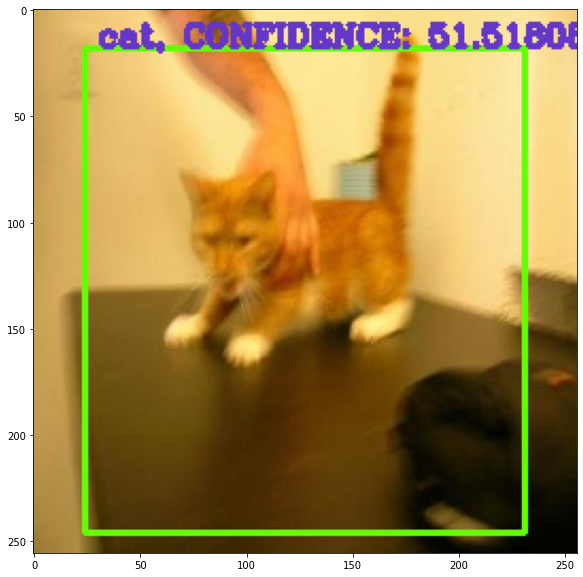

In [ ]:
image = 'dataset/images/cat.0.jpg'
predict(image)

# ONNX

In [ ]:
model = Network()
model = model.to(device)
model.load_state_dict(torch.load("models/model_ep30.pth"))
model.eval()
img  = cv2.imread(image)
# Resize all images to a fix size
image = cv2.resize(img, (256, 256))
# # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Normalize the image by dividing it by 255.0 
image = image.astype("float") / 255.0
y_result = model(torch.permute(torch.from_numpy(image).unsqueeze(0).float(),(0,3,1,2)).to(device))
y_result

[tensor([[0.5152, 0.4848]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([[0.0961, 0.0709, 0.9055, 0.9622]], device='cuda:0',
        grad_fn=<SigmoidBackward0>)]